# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import os
import datetime
import time
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline

from pyspark.ml.feature import Normalizer, MinMaxScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import isnan, udf, isnull,sum
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import Window

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()

In [3]:
# Spark Context Configuration
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.driver.host', '7f2c24f90b96'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '40359'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1559565139932'),
 ('spark.app.name', 'Sparkify Project')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
#Read Data
sparkify_data = 'mini_sparkify_event_data.json'
df_sparkify_user_log = spark.read.json(sparkify_data)
df_sparkify_user_log.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
#Print Schema
df_sparkify_user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#Check the number of records
row_count = df_sparkify_user_log.count()
print('The user log contains {0} records'.format(row_count))

The user log contains 286500 records


In [7]:
#View some sample records
df_sparkify_user_log.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [8]:
#Check the statstics of each columns using the describe function
for col in df_sparkify_user_log.columns:
    print(col)
    print('---------------------')
    df_sparkify_user_log.describe(col).show()
    print(' ')

artist
---------------------
+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

 
auth
---------------------
+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

 
firstName
---------------------
+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

 
gender
---------------------
+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

 
itemInSession
---------------------
+-------+------------------+
|summary|     itemInSes

In [9]:
#Check the number of null rows in each column
print("Feature : Null row count: Non-Null row count: Non-null precentage")
print("-------------------------------------------------")
for col in df_sparkify_user_log.columns:
    null_count = df_sparkify_user_log.filter(isnull(df_sparkify_user_log[col])).count()
    print('{0}   :{1} : {2}: {3}'.format(col,null_count,row_count-null_count,(row_count-null_count)/row_count))

Feature : Null row count: Non-Null row count: Non-null precentage
-------------------------------------------------
artist   :58392 : 228108: 0.7961884816753927
auth   :0 : 286500: 1.0
firstName   :8346 : 278154: 0.970869109947644
gender   :8346 : 278154: 0.970869109947644
itemInSession   :0 : 286500: 1.0
lastName   :8346 : 278154: 0.970869109947644
length   :58392 : 228108: 0.7961884816753927
level   :0 : 286500: 1.0
location   :8346 : 278154: 0.970869109947644
method   :0 : 286500: 1.0
page   :0 : 286500: 1.0
registration   :8346 : 278154: 0.970869109947644
sessionId   :0 : 286500: 1.0
song   :58392 : 228108: 0.7961884816753927
status   :0 : 286500: 1.0
ts   :0 : 286500: 1.0
userAgent   :8346 : 278154: 0.970869109947644
userId   :0 : 286500: 1.0


In [10]:
# There are no null values for user id and session id. So check for the empty string
print(df_sparkify_user_log.filter(df_sparkify_user_log['userId'] == '').count())
print(df_sparkify_user_log.filter(df_sparkify_user_log['sessionId'] == '').count())

8346
0


In [11]:
#Remove records with empty session ids
df_sparkify_user_log_clean = df_sparkify_user_log.filter(df_sparkify_user_log['userId'] != '')

In [12]:
# Create a user defined function for formating the timestamp for better readability
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the time stamp on the ts columns
df_sparkify_user_log_clean = df_sparkify_user_log_clean.withColumn("time", get_time(df_sparkify_user_log.ts))

In [13]:
# View sample records to check the new column
df_sparkify_user_log_clean_pd = df_sparkify_user_log_clean.toPandas()
df_sparkify_user_log_clean_pd.head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,time
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16


In [14]:
#Create a temporary view to perform SQL operations
df_sparkify_user_log_clean.createOrReplaceTempView("sparkify_user_log_table")

### Analayze the data in each column

In [15]:
def barplot_visualize(x_label,y_label,df,title):
    '''
        Plots a seaborn barchart based on the inputs provided
        input: 
            x_lable - Values to be displayed on x-axis
            y_label - Values to be displayed on y-axis
            df - Data to be plotted
        outut: None
    '''
    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 6))
    plt.title(title,fontname="MingLiU",fontsize= 16)
    ax = sns.barplot(y=y_label, x=x_label, data=df.toPandas())

In [16]:
# userId
#Get unique values
spark.sql(''' SELECT COUNT(DISTINCT userId) FROM sparkify_user_log_table''').show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



+--------------------+
|count(DISTINCT auth)|
+--------------------+
|                   2|
+--------------------+

+---------+------+
|     auth|counts|
+---------+------+
|Logged In|   225|
|Cancelled|    52|
+---------+------+



/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['MingLiU'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


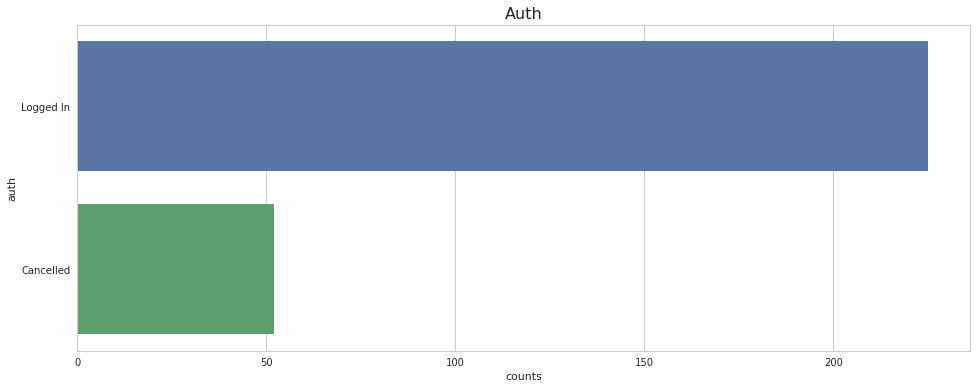

In [17]:
#auth
#Get unique values
spark.sql(''' SELECT COUNT(DISTINCT auth) FROM sparkify_user_log_table''').show()
df_sparkify_auth = spark.sql(''' SELECT auth,COUNT(DISTINCT userId) AS counts 
                            FROM sparkify_user_log_table GROUP BY auth
                            ORDER BY 2 DESC
                            ''')
df_sparkify_auth.show()

#Visualize distibution 
barplot_visualize(x_label="counts",y_label="auth",df=df_sparkify_auth,title='Auth')

+----------------------+
|count(DISTINCT gender)|
+----------------------+
|                     2|
+----------------------+

+------+------+
|gender|counts|
+------+------+
|     M|   121|
|     F|   104|
+------+------+



/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['MingLiU'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


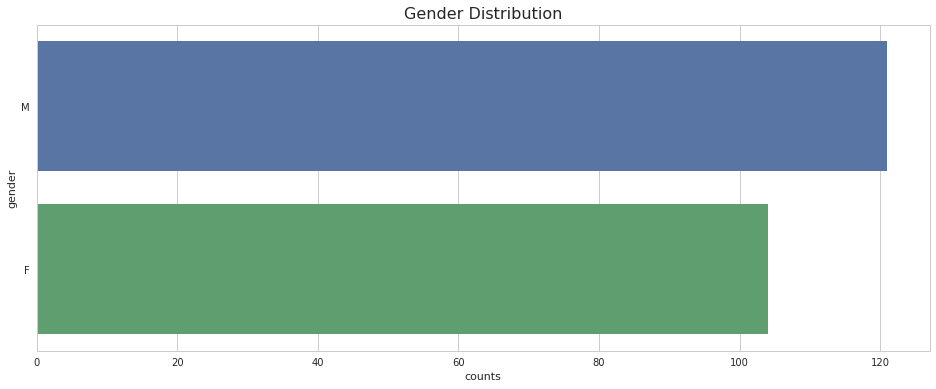

In [18]:
#Gender
#Get unique values
spark.sql(''' SELECT COUNT(DISTINCT gender) FROM sparkify_user_log_table''').show()
df_sparkify_gender = spark.sql(''' 
                                  SELECT gender, COUNT(DISTINCT userId) as counts
                                  FROM sparkify_user_log_table 
                                  GROUP BY gender
                                  ORDER BY COUNT(DISTINCT userId) DESC
                                  ''')
df_sparkify_gender.show()

#Visualize distibution 
barplot_visualize(x_label="counts",y_label="gender",df=df_sparkify_gender,title='Gender Distribution')

+---------------------+
|count(DISTINCT level)|
+---------------------+
|                    2|
+---------------------+

+-----+------+
|level|counts|
+-----+------+
| free|   195|
| paid|   165|
+-----+------+



/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['MingLiU'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


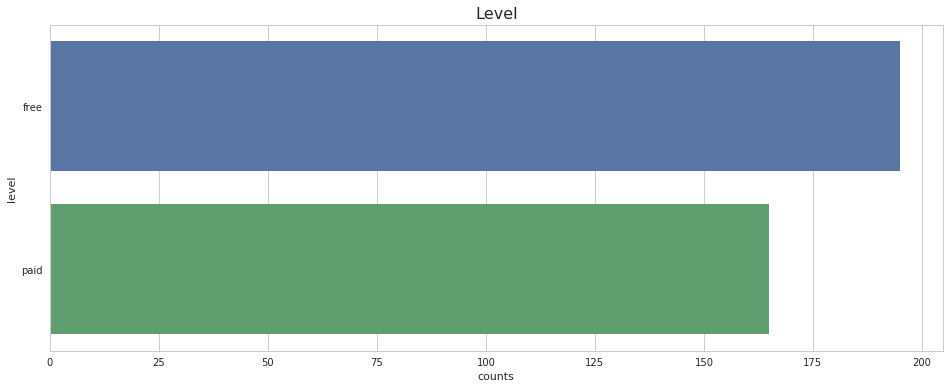

In [19]:
#level
#Get unique values
spark.sql(''' SELECT COUNT(DISTINCT level) FROM sparkify_user_log_table''').show()

df_sparkify_level = spark.sql(''' SELECT level,COUNT(DISTINCT userId) AS counts 
                                FROM sparkify_user_log_table GROUP BY level
                                ORDER BY 2 DESC
                                ''')
df_sparkify_level.show()

#Visualize distibution 
barplot_visualize(x_label="counts",y_label="level",df=df_sparkify_level,title='Level')

+----------------------+
|count(DISTINCT method)|
+----------------------+
|                     2|
+----------------------+

+------+------+
|method|counts|
+------+------+
|   PUT|257818|
|   GET| 20336|
+------+------+



/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['MingLiU'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


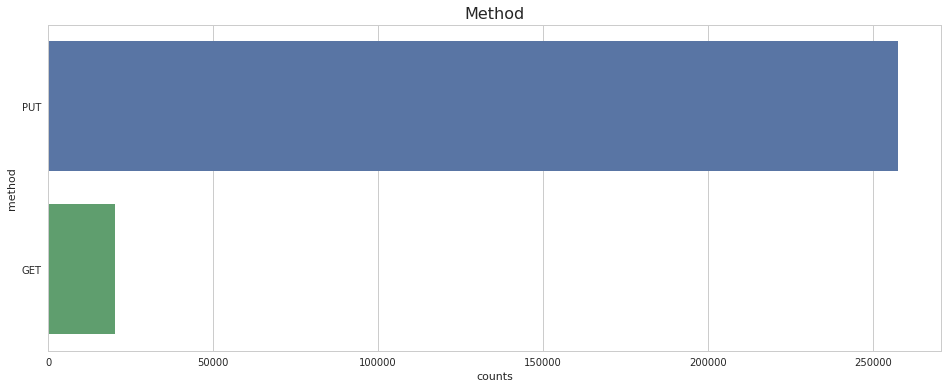

In [20]:
#method
#Get unique values
spark.sql(''' SELECT COUNT(DISTINCT method) FROM sparkify_user_log_table''').show()
df_sparkify_method = spark.sql(''' SELECT method,COUNT(*) AS counts FROM sparkify_user_log_table 
                                    GROUP BY method
                                    ORDER BY 2 DESC
                                    ''')
df_sparkify_method.show()

#Visualize distibution 
barplot_visualize(x_label="counts",y_label="method",df=df_sparkify_method,title = 'Method')

In [21]:
#page
#Get unique values
spark.sql(''' SELECT COUNT(DISTINCT page) FROM sparkify_user_log_table''').show()

df_sparkify_page = spark.sql(''' SELECT userId,page as Page, COUNT(*) AS User_Visit_Count FROM sparkify_user_log_table 
                            WHERE page <> 'NextSong' 
                            GROUP BY userId,page
                            ORDER BY 3 DESC
                            ''')
df_sparkify_page.show()

#Visualize distibution 
#barplot_visualize(x_label="counts",y_label="page",df=df_sparkify_page,title='Page Visits')

+--------------------+
|count(DISTINCT page)|
+--------------------+
|                  19|
+--------------------+

+------+---------------+----------------+
|userId|           Page|User_Visit_Count|
+------+---------------+----------------+
|300011|      Thumbs Up|             437|
|    39|      Thumbs Up|             388|
|    39|           Home|             355|
|300021|      Thumbs Up|             336|
|300017|      Thumbs Up|             303|
|    92|      Thumbs Up|             292|
|   140|      Thumbs Up|             277|
|    92|           Home|             266|
|   140|           Home|             251|
|    39|Add to Playlist|             240|
|300015|      Thumbs Up|             193|
|300011|           Home|             193|
|    85|      Thumbs Up|             192|
|    92|Add to Playlist|             181|
|   124|           Home|             176|
|    42|           Home|             176|
|   124|      Thumbs Up|             171|
|300023|      Thumbs Up|             169|
| 

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Prestige Elite Std'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


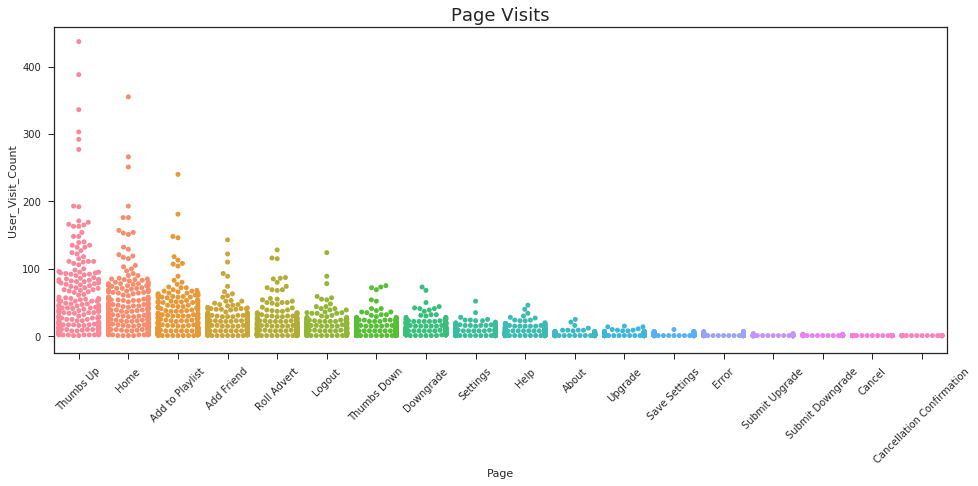

In [22]:
sns.set(style="ticks")
plt.figure(figsize=(16, 6))
plt.xticks(rotation = 45)
plt.title("Page Visits",fontname="Prestige Elite Std",fontsize= 18)
sns.set_palette("Set2",desat=.75)
ax = sns.swarmplot(x="Page", y="User_Visit_Count", data=df_sparkify_page.toPandas())

In [23]:
#status
#Get unique values
spark.sql(''' SELECT COUNT(DISTINCT status) FROM sparkify_user_log_table''').show()
df_sparkify_status = spark.sql(''' SELECT status,COUNT(*) AS counts FROM sparkify_user_log_table 
                                GROUP BY status
                                ORDER BY 2 DESC 
                                    ''')
df_sparkify_status.show()


+----------------------+
|count(DISTINCT status)|
+----------------------+
|                     3|
+----------------------+

+------+------+
|status|counts|
+------+------+
|   200|254718|
|   307| 23184|
|   404|   252|
+------+------+



+-------------------------+
|count(DISTINCT userAgent)|
+-------------------------+
|                       56|
+-------------------------+

+--------------------+------+
|           userAgent|counts|
+--------------------+------+
|"Mozilla/5.0 (Win...| 22751|
|"Mozilla/5.0 (Mac...| 19611|
|"Mozilla/5.0 (Mac...| 18448|
|"Mozilla/5.0 (Mac...| 17348|
|Mozilla/5.0 (Wind...| 16700|
|"Mozilla/5.0 (Win...| 15395|
|"Mozilla/5.0 (Win...| 14598|
|Mozilla/5.0 (Maci...| 10300|
|"Mozilla/5.0 (iPa...|  8912|
|Mozilla/5.0 (comp...|  8624|
|"Mozilla/5.0 (Mac...|  8094|
|"Mozilla/5.0 (Win...|  7923|
|"Mozilla/5.0 (Mac...|  7906|
|"Mozilla/5.0 (Win...|  7624|
|"Mozilla/5.0 (iPh...|  6417|
|Mozilla/5.0 (Wind...|  5989|
|"Mozilla/5.0 (Mac...|  5716|
|"Mozilla/5.0 (Win...|  5238|
|"Mozilla/5.0 (Win...|  4917|
|Mozilla/5.0 (Wind...|  4663|
+--------------------+------+
only showing top 20 rows

+--------------------+------+
|           userAgent|counts|
+--------------------+------+
|"Mozilla/5.0 (Win...| 

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['MingLiU'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


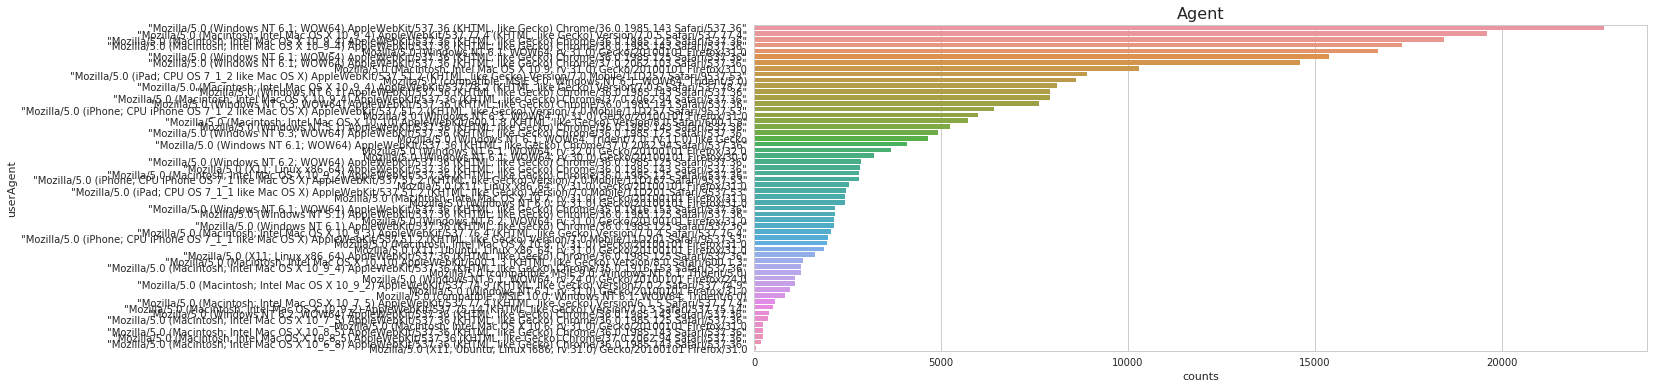

In [24]:
#status
#Get unique values
spark.sql(''' SELECT COUNT(DISTINCT userAgent) FROM sparkify_user_log_table''').show()

df_sparkify_userAgent = spark.sql(''' SELECT userAgent,COUNT(*) AS counts 
                                FROM sparkify_user_log_table 
                                GROUP BY userAgent
                                ORDER BY COUNT(*) DESC
                                ''')
df_sparkify_userAgent.show()
df_sparkify_userAgent = spark.sql(''' SELECT userAgent,COUNT(*) AS counts 
                                FROM sparkify_user_log_table 
                                GROUP BY userAgent
                               -- HAVING COUNT(*) > 10000
                                ORDER BY 2 DESC
                                ''')

df_sparkify_userAgent.show()

#Visualize distibution 
barplot_visualize("counts","userAgent",df_sparkify_userAgent,title='Agent')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [25]:
flg_cancelation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [26]:
# add a new column "churn_event" to mark cancellation event
df_sparkify_user_log_with_churn_col = df_sparkify_user_log_clean.withColumn('churn_event', flg_cancelation_event('page'))

# label users who have churned
windowval = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_sparkify_user_log_final = df_sparkify_user_log_with_churn_col.withColumn('churn', sum('churn_event').over(windowval))

#Create a temporary view to perform SQL operations
df_sparkify_user_log_final.createOrReplaceTempView("sparkify_user_log_table")

In [27]:
spark.sql(
            '''SELECT 
            churn,
             --(case when churn = 0 then 'No' else 'Yes' end)  as churned?,
             COUNT(DISTINCT userId) as Count
             FROM
             sparkify_user_log_table GROUP BY churn'''
          ).show()

+-----+-----+
|churn|Count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [28]:
df_sparkify_page = spark.sql('''   SELECT
                churn,page, cast((COUNT(page)/44864*100) as decimal (10,2)) as mean
                FROM sparkify_user_log_table
                WHERE churn = 1 AND page != 'NextSong'
                GROUP BY churn,page
                UNION
                SELECT
                churn,page, cast((COUNT(page)/233290*100) as decimal (10,2)) as mean
                FROM sparkify_user_log_table
                WHERE churn = 0 AND page != 'NextSong'
                GROUP BY churn,page
                ORDER BY mean DESC 
                ''')

In [29]:
df_sparkify_page = spark.sql('''   SELECT
                (case when churn = 0 then 'No' else 'Yes' end) as churn,
                userId,page, cast((COUNT(page)/44864*100) as decimal (10,2)) as mean
                FROM sparkify_user_log_table
                WHERE churn = 0 AND page != 'NextSong'
                GROUP BY churn,userId,page
                
                UNION
                
                SELECT
                (case when churn = 0 then 'No' else 'Yes' end),userId,page, cast((COUNT(page)/233290*100) as decimal (10,2)) as mean
                FROM sparkify_user_log_table
                WHERE churn = 1 AND page != 'NextSong'
                GROUP BY churn,userId,page
                ORDER BY mean DESC 
                ''')

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Prestige Elite Std'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


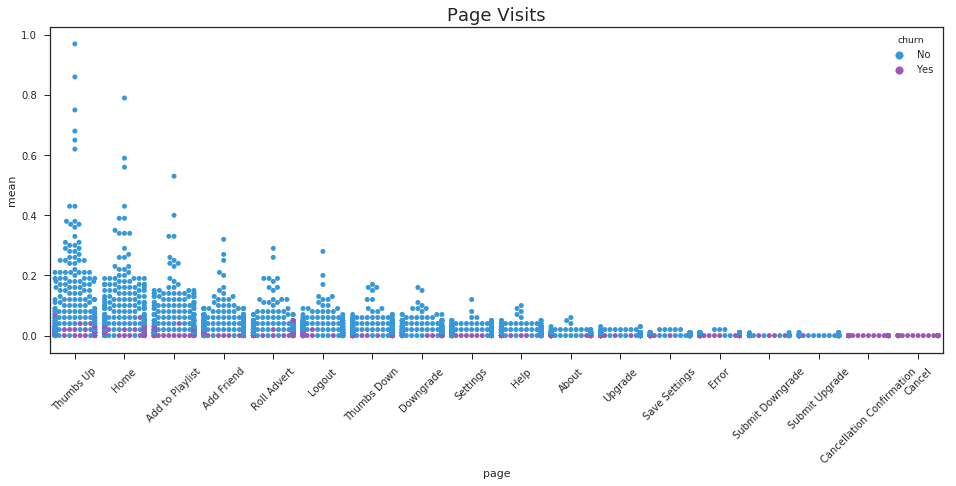

In [30]:
sns.set(style="ticks")
plt.figure(figsize=(16, 6))
plt.xticks(rotation = 45)
plt.title("Page Visits",fontname="Prestige Elite Std",fontsize= 18)
#sns.set_palette("Set1",n_colors=2, desat=.75)
ax = sns.swarmplot(x="page", y="mean", data=df_sparkify_page.toPandas(),hue="churn",palette=dict(Yes="#9b59b6", No="#3498db"))

In [31]:
spark.udf.register("get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))
df_sparkifysongs_in_hour = spark.sql('''
          SELECT churn, get_hour(ts) AS hour, COUNT(*)/44864*100 as plays_per_hour
          FROM sparkify_user_log_table
          WHERE page = "NextSong" AND churn = 1
          GROUP BY churn, hour
          UNION
          SELECT churn, get_hour(ts) AS hour, COUNT(*)/233290*100 as plays_per_hour
          FROM sparkify_user_log_table
          WHERE page = "NextSong" AND churn = 0
          GROUP BY churn, hour
              ORDER BY hour ASC
          '''
          )

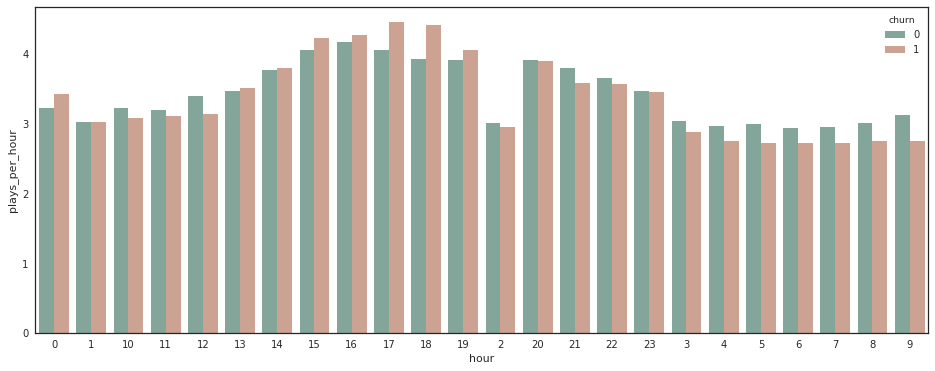

In [32]:
sns.set_style("white")
plt.figure(figsize=(16, 6))
sns.set_palette("Set2",n_colors=8, desat=.5)
ax = sns.barplot(x="hour", y="plays_per_hour", hue="churn", data=df_sparkifysongs_in_hour.toPandas(),capsize=.2)

In [33]:
# Most Listened Songs
df_sparkify_songs_nochurn = spark.sql('''
          SELECT
              churn,song,COUNT(*) as song_count
              FROM
              sparkify_user_log_table
              WHERE churn = 0 AND song is not null
              GROUP BY churn,song
              ORDER BY song_count DESC
          '''
          )

df_sparkify_songs_churn = spark.sql('''
          SELECT
              churn,song,COUNT(*) as song_count
              FROM
              sparkify_user_log_table
              WHERE churn = 1 AND song is not null
              GROUP BY churn,song
              ORDER BY song_count DESC
          '''
          )

# Most Listened Artists
df_sparkify_artist_nochurn = spark.sql('''
          SELECT
              churn,artist,COUNT(artist) as artist_count
              FROM
              sparkify_user_log_table
              WHERE churn = 0 AND artist is not null
              GROUP BY churn,artist
              ORDER BY artist_count DESC
          '''
          )

df_sparkify_artist_churn = spark.sql('''
          SELECT
              churn,artist,COUNT(artist) as artist_count
              FROM
              sparkify_user_log_table
              WHERE churn = 1 AND artist is not null
              GROUP BY churn,artist
              ORDER BY artist_count DESC
          '''
          )


In [34]:
df_sparkify_songs_nochurn_pd = df_sparkify_songs_nochurn.toPandas().iloc[0:5]
df_sparkify_songs_churn_pd = df_sparkify_songs_churn.toPandas().iloc[0:5]
df_sparkify_artist_nochurn_pd = df_sparkify_artist_nochurn.toPandas().iloc[0:5]
df_sparkify_artist_churn_pd = df_sparkify_artist_churn.toPandas().iloc[0:5]

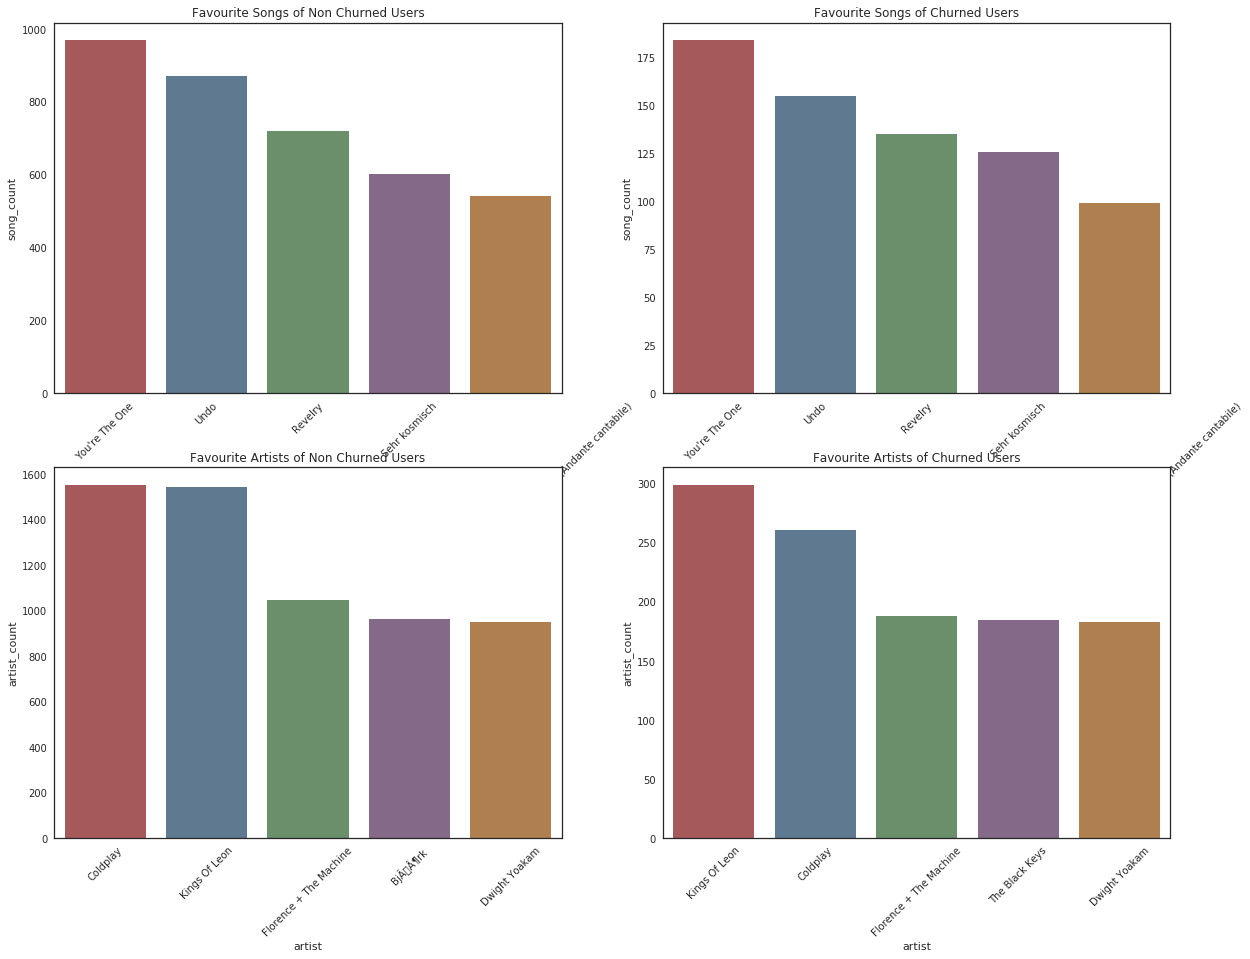

In [35]:
plt.figure(figsize=(20,15))
sns.set_palette("Set1",n_colors=8, desat=.5)
plt.subplot(2, 2, 1)
sns.barplot(x="song", y="song_count", data=df_sparkify_songs_nochurn_pd,capsize=.2)
plt.xticks(rotation = 45)
plt.title('Favourite Songs of Non Churned Users')

plt.subplot(2, 2, 2)
sns.barplot(x="song", y="song_count", data=df_sparkify_songs_churn_pd,capsize=.2)
plt.xticks(rotation = 45)
plt.title('Favourite Songs of Churned Users')


plt.subplot(2, 2, 3)    
sns.barplot(x="artist", y="artist_count", data=df_sparkify_artist_nochurn_pd,capsize=.2)
plt.xticks(rotation = 45)
plt.title('Favourite Artists of Non Churned Users')

plt.subplot(2, 2, 4)    
sns.barplot(x="artist", y="artist_count", data=df_sparkify_artist_churn_pd,capsize=.2)
plt.xticks(rotation = 45)
plt.title('Favourite Artists of Churned Users')

plt.legend();

In [36]:
# Most Listened Songs
wc_df_sparkify_songs_nochurn = spark.sql('''
          SELECT
              churn,song
              FROM
              sparkify_user_log_table
              WHERE churn = 0 AND song is not null
          '''
          )


wc_df_sparkify_songs_churn = spark.sql('''
          SELECT
              churn,song
              FROM
              sparkify_user_log_table
              WHERE churn = 1 AND song is not null
          '''
          )


# Most Listened Artists
wc_df_sparkify_artist_nochurn = spark.sql('''
          SELECT
              churn,artist
              FROM
              sparkify_user_log_table
              WHERE churn = 0 AND artist is not null
          '''
          )


wc_df_sparkify_artist_churn = spark.sql('''
          SELECT
              churn,artist
              FROM
              sparkify_user_log_table
              WHERE churn = 1 AND artist is not null
          '''
          )


In [37]:
wc_df_sparkify_songs_nochurn_pd = wc_df_sparkify_songs_nochurn.toPandas()
wc_df_sparkify_songs_churn_pd = wc_df_sparkify_songs_churn.toPandas()
wc_df_sparkify_artist_nochurn_pd = wc_df_sparkify_artist_nochurn.toPandas()
wc_df_sparkify_artist_churn_pd = wc_df_sparkify_artist_churn.toPandas()

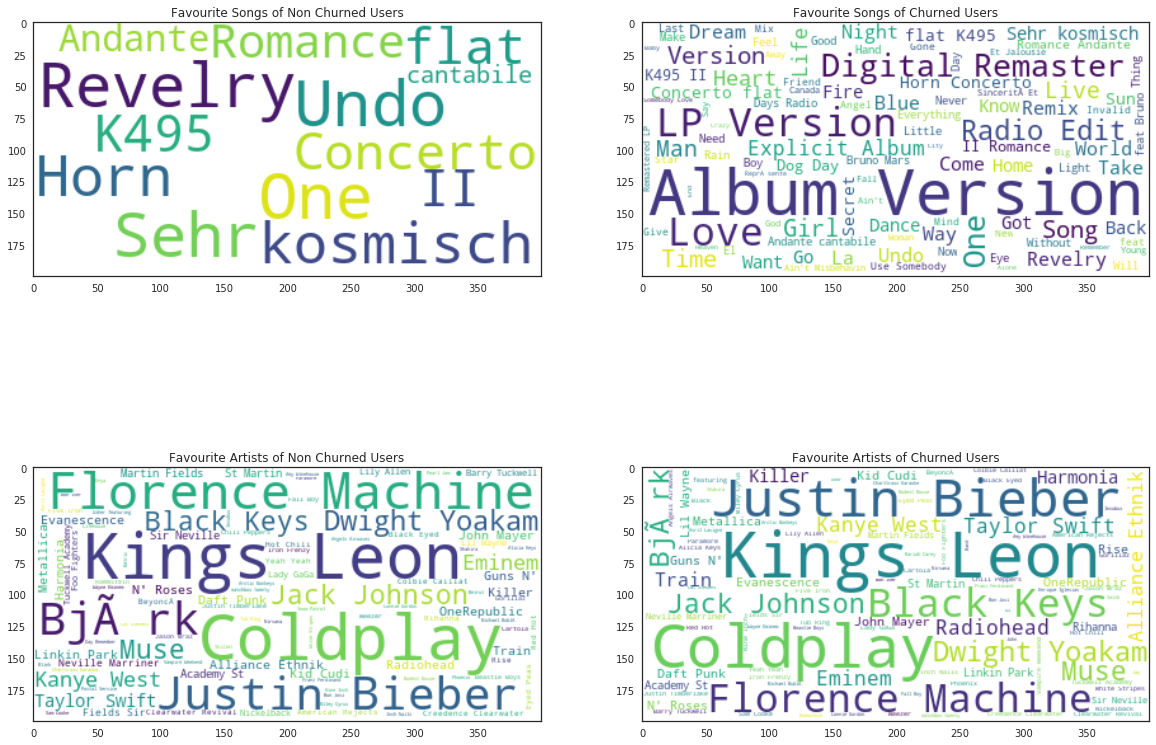

In [38]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
text =   ' '.join(df_sparkify_songs_nochurn_pd['song'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Favourite Songs of Non Churned Users')

plt.subplot(2, 2, 2)
text =   ' '.join(wc_df_sparkify_songs_churn_pd['song'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Favourite Songs of Churned Users')

plt.subplot(2, 2, 3)
text =   ' '.join(wc_df_sparkify_artist_nochurn_pd['artist'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Favourite Artists of Non Churned Users')

plt.subplot(2, 2, 4)
text =   ' '.join(wc_df_sparkify_artist_churn_pd['artist'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Favourite Artists of Churned Users')

plt.legend();

In [39]:
#plt.figure(figsize=(20, 10)
#sns.set_palette("Set1")

#fig, ax =plt.subplots(2,2)

#ax1 = fig.add_subplot (sns.barplot(x="song", y="song_count", data=df_sparkify_songs_nochurn_pd,capsize=.2))
#ax2 = fig.add_subplot (sns.barplot(x="song", y="song_count", data=df_sparkify_songs_churn_pd,capsize=.2))
#ax3 = fig.add_subplot (sns.barplot(x="artist", y="artist_count", data=df_sparkify_artist_nochurn_pd,capsize=.2))
#ax4 = fig.add_subplot (sns.barplot(x="artist", y="artist_count", data=df_sparkify_artist_churn_pd,capsize=.2))
#fig.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Following features are shortlisted for building the model.
- gender: Gender
- level: Access Level - Free Tier or Premium
- song_count: Number of songs listened to
- artist_count: Number of artists listened to 
- song_time: Total duration of the music played
- duration: Duration from the time of registration till today
- submit_downgrade_count: Number of downgrade submits
- thumbs_down_count: Number of thumbs down
- downgrade_count: Number of downgrades
- roll_advert_count
- add_to_playlist_count: Add to playlist count
- add_friend_count: Add friend count
- thumbs_up_count: Number of thumbs up
- help_count: help count
- upgrade_count: Number of upgrades
- error_count: Error count
- submit_upgrade_count: Number of upgrade submits

In [40]:
spark.sql('''SELECT COUNT(*) FROM sparkify_user_log_table ''').show()
spark.sql('''SELECT COUNT(DISTINCT(userId,churn)) FROM sparkify_user_log_table ''').show()

+--------+
|count(1)|
+--------+
|  278154|
+--------+

+----------------------------------------------------------+
|count(DISTINCT named_struct(userId, userId, churn, churn))|
+----------------------------------------------------------+
|                                                       225|
+----------------------------------------------------------+



In [41]:
#df_sparkify_feature_sel = spark.sql('''
#          SELECT DISTINCT 
#          userId,  
#          churn,
#          (case when gender = 'F' then 0 else 1 end) as gender,
#          (case when level = 'free' then 0 else 1 end) as level,
#          count(distinct song) as song_count,
#          count(distinct artist) as artist_count,
#          sum(length) song_time,
#          max(ts-registration) as duration,
#          sum(case when page = 'Submit Downgrade' then 1 else 0 end) as submit_downgrade_count,
#          sum(case when page = 'Thumbs Down' then 1 else 0 end) as thumbs_down_count,
#          sum(case when page = 'Downgrade' then 1 else 0 end) as downgrade_count,
#          sum(case when page = 'Roll Advert' then 1 else 0 end) as roll_advert_count,
#          sum(case when page = 'Add to Playlist' then 1 else 0 end) as add_to_playlist_count,
#          sum(case when page = 'Add Friend' then 1 else 0 end) as add_friend_count,
#          sum(case when page = 'Thumbs Up' then 1 else 0 end) as thumbs_up_count,
#          sum(case when page = 'Help' then 1 else 0 end) as help_count,
#          sum(case when page = 'Upgrade' then 1 else 0 end) as upgrade_count,
#          sum(case when page = 'Error' then 1 else 0 end) as error_count,
#          sum(case when page = 'Submit Upgrade' then 1 else 0 end) as submit_upgrade_count
#          FROM sparkify_user_log_table
#          GROUP BY userId,churn,gender,level
#          ''')
#
#df_features = df_sparkify_feature_sel.toPandas()

In [42]:
#Prepare the data set for the machine learning model
# The column churn is rename as label and data type changed to float
df_sparkify_feature_sel = spark.sql('''
          SELECT DISTINCT 
          userId,  
          CAST(churn AS FLOAT) as label,
          (case when gender = 'F' then 0 else 1 end) as gender,
          (case when level = 'free' then 0 else 1 end) as level,
          COUNT(distinct song)/MAX(ts-registration) as song_count,
          COUNT(distinct artist)/MAX(ts-registration) as artist_count,
          COUNT(distinct sessionId)/MAX(ts-registration) as session_count,
          AVG(length) song_time,
          MAX(ts-registration) as duration,
          SUM(case when page = 'Submit Downgrade' then 1 else 0 end)/MAX(ts-registration) as submit_downgrade_count,
          SUM(case when page = 'Thumbs Down' then 1 else 0 end)/MAX(ts-registration) as thumbs_down_count,
          SUM(case when page = 'Downgrade' then 1 else 0 end)/MAX(ts-registration) as downgrade_count,
          SUM(case when page = 'Roll Advert' then 1 else 0 end)/MAX(ts-registration) as roll_advert_count,
          SUM(case when page = 'Add to Playlist' then 1 else 0 end)/MAX(ts-registration) as add_to_playlist_count,
          SUM(case when page = 'Add Friend' then 1 else 0 end)/MAX(ts-registration) as add_friend_count,
          SUM(case when page = 'Thumbs Up' then 1 else 0 end)/MAX(ts-registration) as thumbs_up_count,
          SUM(case when page = 'Help' then 1 else 0 end)/MAX(ts-registration) as help_count,
          SUM(case when page = 'Upgrade' then 1 else 0 end)/MAX(ts-registration) as upgrade_count,
          SUM(case when page = 'Error' then 1 else 0 end)/MAX(ts-registration) as error_count,
          SUM(case when page = 'Submit Upgrade' then 1 else 0 end)/MAX(ts-registration) as submit_upgrade_count
          FROM sparkify_user_log_table
          GROUP BY userId,churn,gender,level
          ''')

df_features = df_sparkify_feature_sel.toPandas()

In [43]:
print(df_features.shape)
df_features.isna().sum()

(360, 20)


userId                    0
label                     0
gender                    0
level                     0
song_count                0
artist_count              0
session_count             0
song_time                 1
duration                  0
submit_downgrade_count    0
thumbs_down_count         0
downgrade_count           0
roll_advert_count         0
add_to_playlist_count     0
add_friend_count          0
thumbs_up_count           0
help_count                0
upgrade_count             0
error_count               0
submit_upgrade_count      0
dtype: int64

Replace all the null values

In [44]:
#Replace the null values with 0
df_sparkify_feature_sel = df_sparkify_feature_sel.fillna(0,subset=['song_time'])
df_features = df_sparkify_feature_sel.toPandas()

print(df_features.isna().sum())

userId                    0
label                     0
gender                    0
level                     0
song_count                0
artist_count              0
session_count             0
song_time                 0
duration                  0
submit_downgrade_count    0
thumbs_down_count         0
downgrade_count           0
roll_advert_count         0
add_to_playlist_count     0
add_friend_count          0
thumbs_up_count           0
help_count                0
upgrade_count             0
error_count               0
submit_upgrade_count      0
dtype: int64


Text(0.5,0.98,'Userlog Attributes Correlation Heatmap')

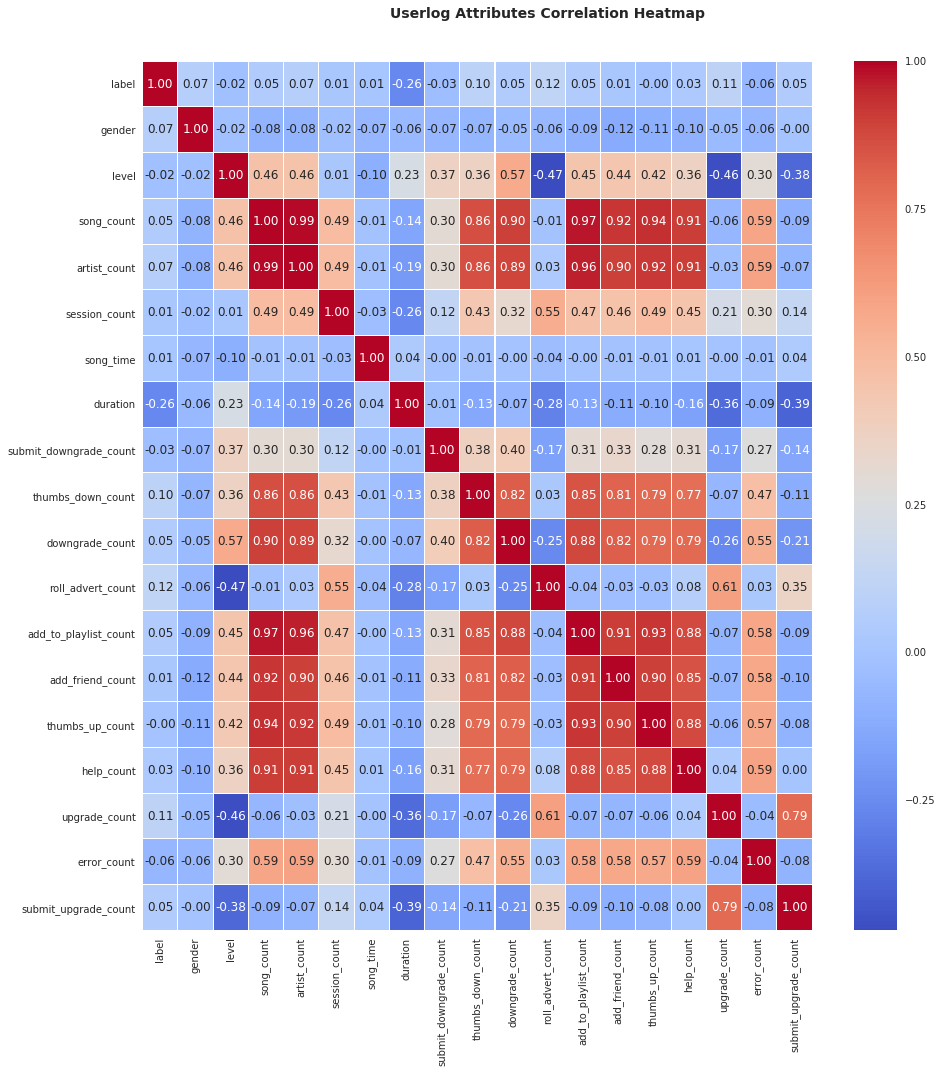

In [45]:
corr = df_features.corr()
fig, ax = plt.subplots(figsize=(15,15))  
hm = sns.heatmap(corr, cmap="coolwarm",annot=True,fmt='.2f',linewidths=.05)
fig.subplots_adjust(top=0.93)
fig.suptitle('Userlog Attributes Correlation Heatmap', fontsize=14, fontweight='bold')

#### Feature Scaling

1. Vectorize
2. Scale - So that features dont dominate others

### Create Machine Learing Pipeline
### 1. Feature Scaling
- Vectorize
- Scale - So that features dont dominate others

In [46]:
#Identify the columns for vectorize
input_cols = df_sparkify_feature_sel.columns[2:]

# Split the data set into train and test
train, test = df_sparkify_feature_sel.randomSplit([0.80, 0.20], seed=45)

#Vectorize and Scale
assembler = VectorAssembler(inputCols=input_cols, outputCol="NumFeatures")
scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="features")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [47]:
pd_ml_results = []
pd_ml_results = pd.DataFrame(pd_ml_results)
pd_ml_results['Evaluations'] = ['Accuracy','F1_Score']

In [48]:
#Define Machine learning classifiers
lr_classifier = LogisticRegression(maxIter=10,regParam=0.0,elasticNetParam=0)
gbt_classifier = GBTClassifier(maxIter=10,seed=42)
svm_classifier = LinearSVC(maxIter=10)
rf_classifier = RandomForestClassifier()

In [49]:
#Define pipelines
lr_pipeline = Pipeline(stages=[assembler, scaler, lr_classifier]);
gbt_pipeline = Pipeline(stages=[assembler, scaler, gbt_classifier]);
svm_pipeline = Pipeline(stages=[assembler, scaler, svm_classifier]);
rf_pipeline = Pipeline(stages=[assembler, scaler, rf_classifier]);

In [50]:
#Define param grids
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr_classifier.maxIter, [5, 10, 20]) \
    .addGrid(lr_classifier.regParam, [0.1, 0.01]) \
    .addGrid(lr_classifier.elasticNetParam,[0.0, 0.5]) \
    .addGrid(lr_classifier.aggregationDepth,[2, 5]) \
    .build()

gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt_classifier.maxIter, [5, 10, 20]) \
    .addGrid(gbt_classifier.maxDepth, [2, 4, 6, 8]) \
    .build()

svm_paramGrid = ParamGridBuilder() \
    .addGrid(svm_classifier.maxIter, [5, 10, 20]) \
    .build()

rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf_classifier.impurity,['entropy', 'gini']) \
    .addGrid(rf_classifier.maxDepth,[2, 4, 6, 8]) \
    .addGrid(rf_classifier.numTrees,[10, 25, 50, 100]) \
    .build()

In [51]:
#Define param grids
#lr_paramGrid = ParamGridBuilder() \
#    .addGrid(lr_classifier.maxIter, [5, 10, 20]) \
#    .build()

#gbt_paramGrid = ParamGridBuilder() \
#    .addGrid(gbt_classifier.maxIter, [5, 10, 20]) \
#    .build()

#svm_paramGrid = ParamGridBuilder() \
#    .addGrid(svm_classifier.maxIter, [5, 10, 20]) \
#    .build()

#rf_paramGrid = ParamGridBuilder() \
#    .addGrid(rf_classifier.numTrees,[10, 25, 50, 100]) \
#    .build()

In [52]:
#Define Cross Validators
lr_crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

gbt_crossval = CrossValidator(estimator=gbt_pipeline,
                          estimatorParamMaps=gbt_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

svm_crossval = CrossValidator(estimator=svm_pipeline,
                          estimatorParamMaps=svm_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

rf_crossval = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

#### Logistic Regression 

In [53]:
from workspace_utils import keep_awake
for i in keep_awake(range(1)):
    start_time = time.time()

    #lr_model = lr_pipeline.fit(train)
    #lr_predict = lr_model.transform(test)

    lr_model = lr_crossval.fit(train)
    lr_predict = lr_model.transform(test)


    lr_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

    lr_accuracy = lr_evaluator.evaluate(lr_predict, {lr_evaluator.metricName: "accuracy"})
    lr_f1score = lr_evaluator.evaluate(lr_predict, {lr_evaluator.metricName: "f1"})

    end_time = time.time()
    print('Elapsed Time: {}'.format(np.round(((end_time - start_time)/60),2)))


print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(lr_accuracy))
print('F-1 Score:{}'.format(lr_f1score))

pd_ml_results['LogisticRegression'] = [lr_accuracy,lr_f1score]

Elapsed Time: 49.06
Logistic Regression Metrics:
Accuracy: 0.7246376811594203
F-1 Score:0.651317984651318


#### Gradient Boosted Trees 

In [54]:
from workspace_utils import keep_awake
for i in keep_awake(range(1)):
    start_time = time.time()
    
    #gbt_model = gbt_pipeline.fit(train)
    #gbt_predict = gbt_model.transform(test)

    gbt_model = gbt_crossval.fit(train)
    gbt_predict = gbt_model.transform(test)


    gbt_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

    gbt_accuracy = gbt_evaluator.evaluate(gbt_predict, {gbt_evaluator.metricName: "accuracy"})
    gbt_f1score = gbt_evaluator.evaluate(gbt_predict, {gbt_evaluator.metricName: "f1"})

    end_time = time.time()
    print('Elapsed Time: {}'.format(np.round(((end_time - start_time)/60),2)))


print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(gbt_accuracy))
print('F-1 Score:{}'.format(gbt_f1score))

pd_ml_results['GradientBoostedTrees'] = [gbt_accuracy,gbt_f1score]

Elapsed Time: 89.42
Gradient Boosted Trees Metrics:
Accuracy: 0.7101449275362319
F-1 Score:0.6912280701754385


#### Support Vector Machine

In [55]:
from workspace_utils import keep_awake
for i in keep_awake(range(1)):
    start_time = time.time()

    #svm_model = svm_pipeline.fit(train)
    #svm_predict = svm_model.transform(test)

    svm_model = svm_crossval.fit(train)
    svm_predict = svm_model.transform(test)


    svm_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

    svm_accuracy = svm_evaluator.evaluate(svm_predict, {svm_evaluator.metricName: "accuracy"})
    svm_f1score = svm_evaluator.evaluate(svm_predict, {svm_evaluator.metricName: "f1"})

    end_time = time.time()
    print('Elapsed Time: {}'.format(np.round(((end_time - start_time)/60),2)))


print('SupportVectorMachine Metrics:')
print('Accuracy: {}'.format(svm_accuracy))
print('F-1 Score:{}'.format(svm_f1score))

pd_ml_results['SupportVectorMachine(SVM)'] = [svm_accuracy,svm_f1score]

Elapsed Time: 15.18
SupportVectorMachine Metrics:
Accuracy: 0.6666666666666666
F-1 Score:0.5333333333333334


#### Random Forest 

In [56]:
from workspace_utils import keep_awake
for i in keep_awake(range(1)):
    start_time = time.time()

    #rf_model = rf_pipeline.fit(train)
    #rf_predict = rf_model.transform(test)

    rf_model = rf_crossval.fit(train)
    rf_predict = rf_model.transform(test)


    rf_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

    rf_accuracy = rf_evaluator.evaluate(rf_predict, {rf_evaluator.metricName: "accuracy"})
    rf_f1score = rf_evaluator.evaluate(rf_predict, {rf_evaluator.metricName: "f1"})

    end_time = time.time()
    print('Elapsed Time: {}'.format(np.round(((end_time - start_time)/60),2)))

print('Random Forest Metrics:')
print('Accuracy: {}'.format(rf_accuracy))
print('F-1 Score:{}'.format(rf_f1score))

pd_ml_results['RandomForest'] = [rf_accuracy,rf_f1score]

Elapsed Time: 67.85
Random Forest Metrics:
Accuracy: 0.6956521739130435
F-1 Score:0.6433524268917697


In [57]:
print(pd_ml_results)

  Evaluations  LogisticRegression  GradientBoostedTrees  \
0    Accuracy            0.724638              0.710145   
1    F1_Score            0.651318              0.691228   

   SupportVectorMachine(SVM)  RandomForest  
0                   0.666667      0.695652  
1                   0.533333      0.643352  


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [58]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Sparkify.ipynb to html',
 '[NbConvertApp] Writing 2310516 bytes to Sparkify.html']